# 학생증 학번 인식 프로젝트

## Open CV 및 Tensorflow 활용

## 라이브러리 선언

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

## 이미지 불러오기

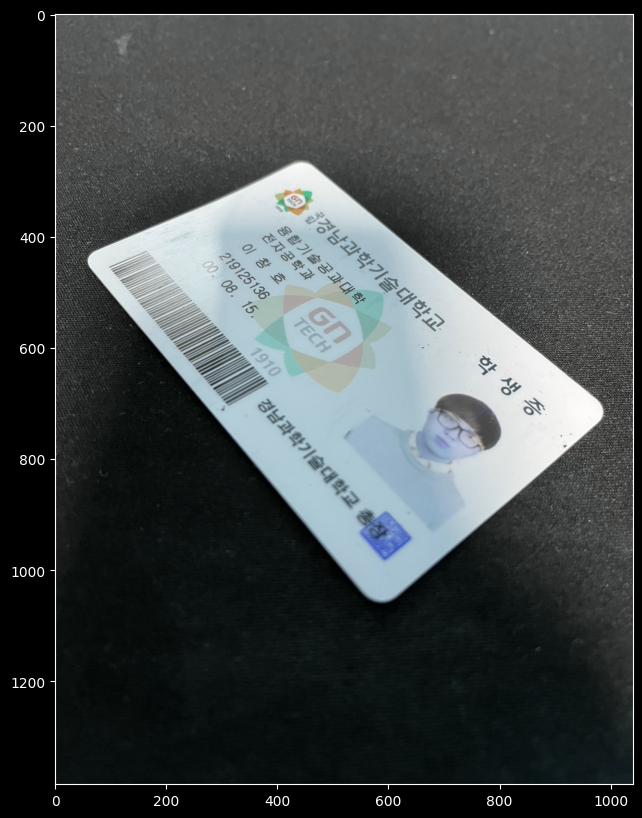

In [2]:
img_ori = cv2.imread('Student ID Card.jpg')

height, width, channel = img_ori.shape

plt.figure(figsize=(12,10))
plt.imshow(img_ori, cmap='gray')

## 흑백으로 변환

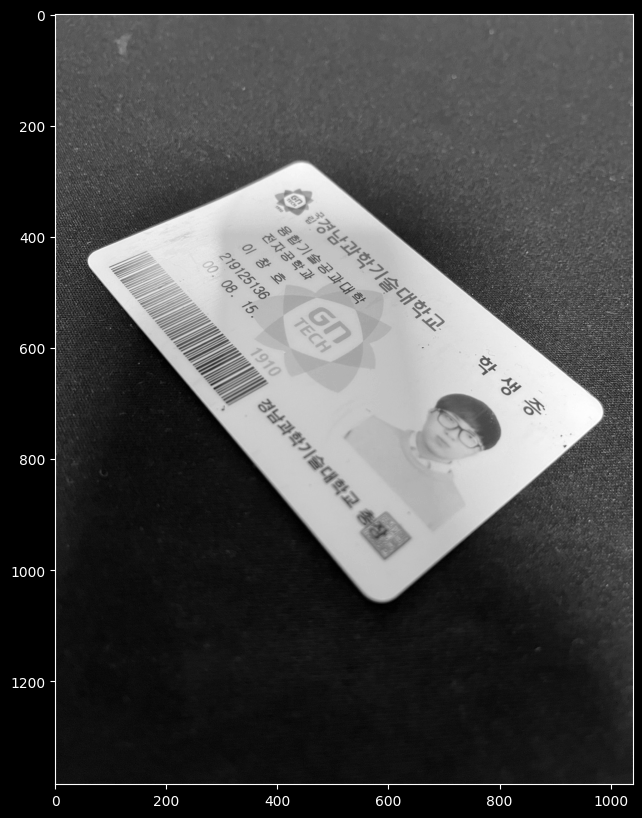

In [3]:
# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,2]

gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,10))
plt.imshow(gray, cmap='gray')

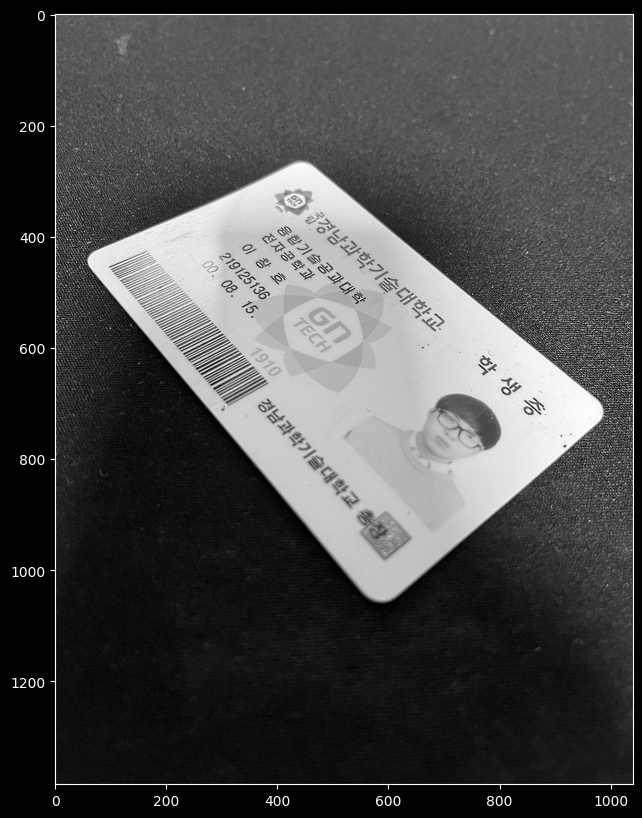

In [4]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

## 이미지 회전 - 그림판에서 각 꼭지점 위치 찾음

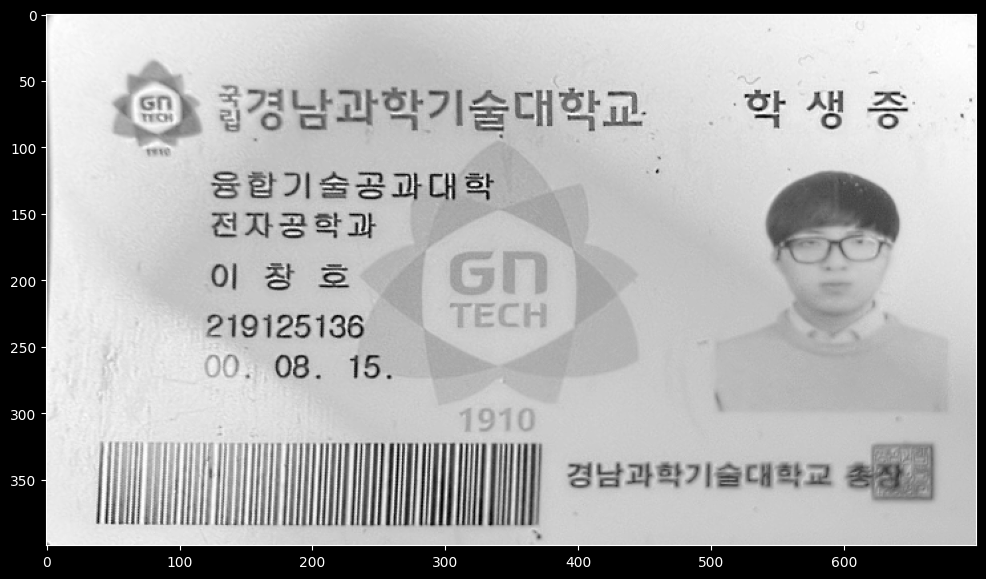

In [5]:
width, height = 700, 400 # 가로 크기 700, 세로 크기 400으로 결과물 출력

src = np.array([[441, 265], [987, 713], [584, 1056], [57, 439]], dtype=np.float32) # Input 4개 지점 (꼭지점 4개의 좌표로 그림판에서 점 찍으면 나옴)
dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32) # Output 4개 지점
# 좌상, 우상, 우하, 좌하 (시계방향으로 4 지점 정의)

matrix = cv2.getPerspectiveTransform(src, dst) #Metrix 얻어 옴
rotated = cv2.warpPerspective(gray, matrix, (width, height)) # matrix 대로 변환

plt.figure(figsize=(12, 10))
plt.imshow(rotated, cmap='gray')

## Adaptive Thresholding 사용

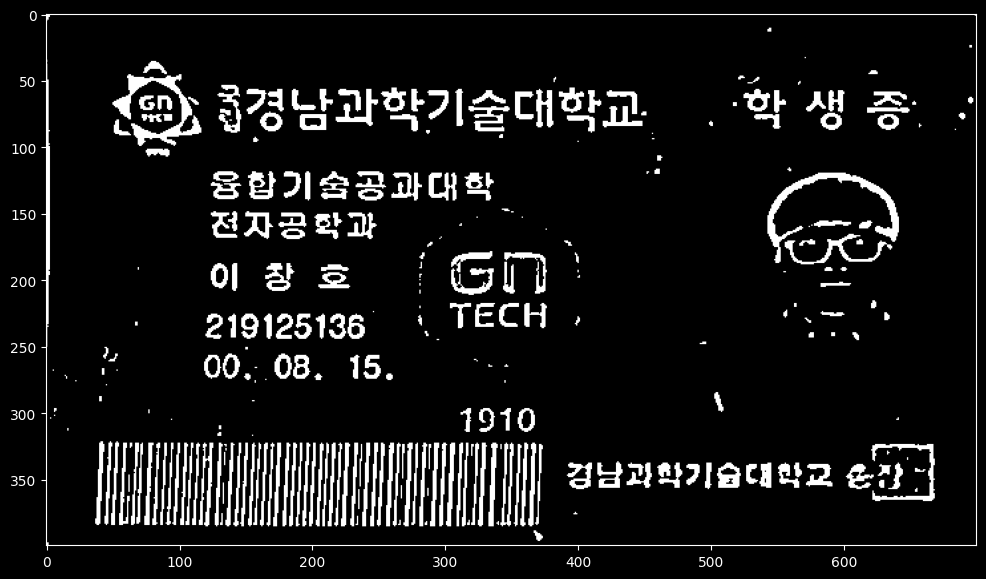

In [6]:
#GaussianBlur: 노이즈를 줄이기 위해서
#adaptiveThreshold: 이미지 구별 쉽게 0 or 255 로 (검정 or 흰색으로)

img_blurred = cv2.GaussianBlur(rotated, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

## Contours() : 윤곽선 찾기

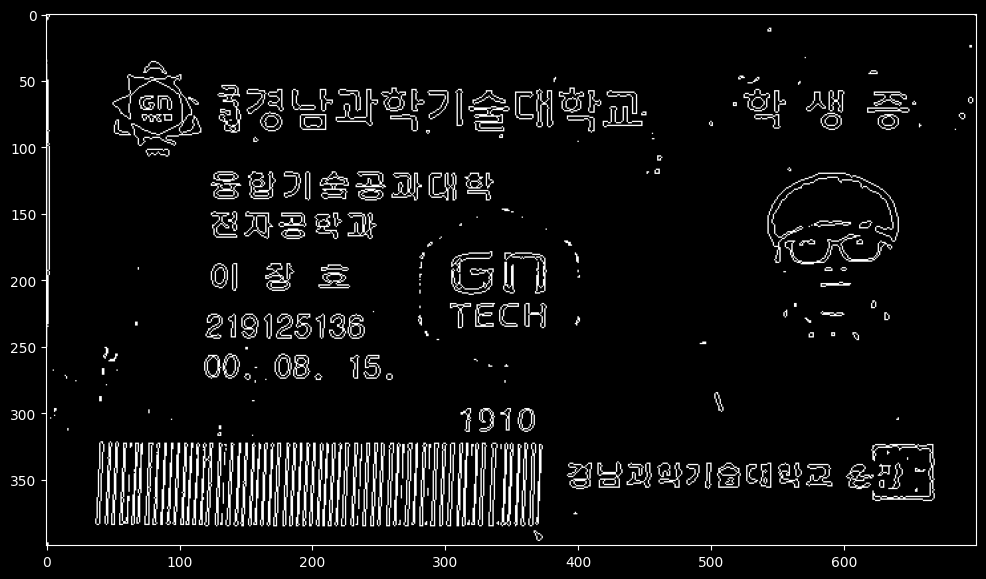

In [14]:
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

## 경계선에 네모칸 만들기

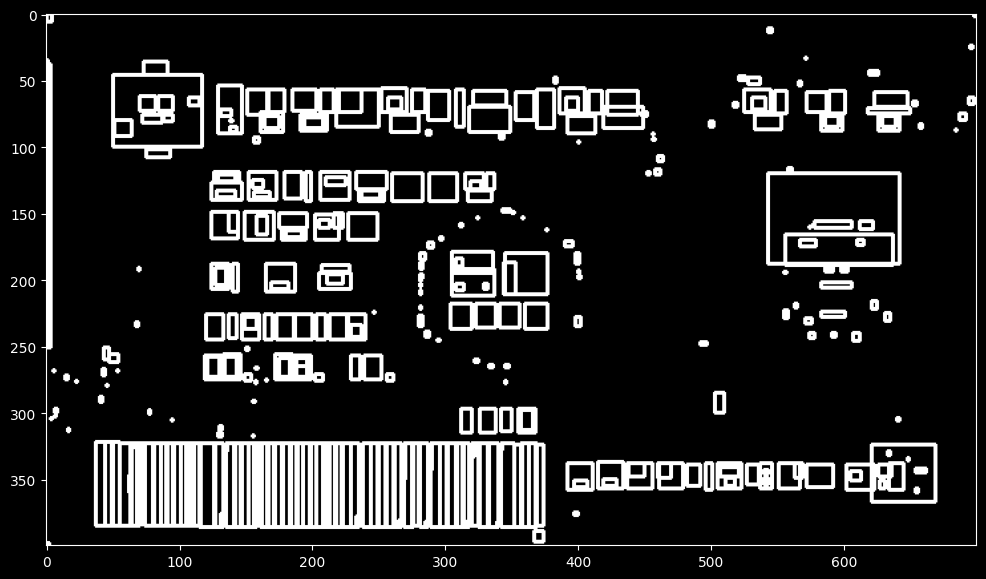

In [8]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## 학번 크기의 네모칸만 분류하기

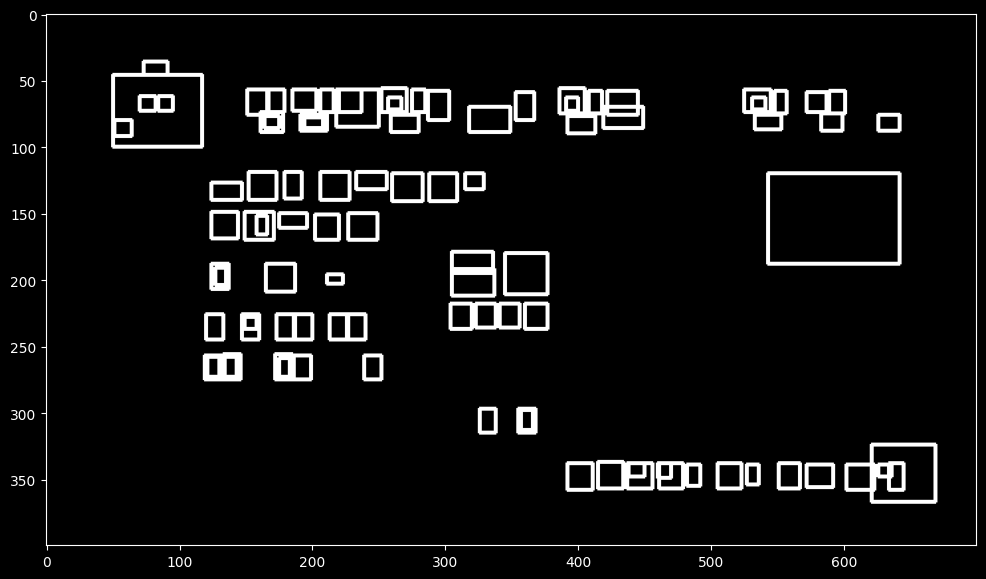

In [9]:
MIN_AREA = 80  # 학번 윤곽선 최소 범위 지정
MIN_WIDTH, MIN_HEIGHT = 1, 4         # 최소 너비 높이 범위 지정
MIN_RATIO, MAX_RATIO = 0.5, 2     # 최소 비율 범위 지정

possible_contours = []  # possible_contours에 저장

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    
  # 위에 설정한 범위의 조건을 비교, 맞추면서 다시한번 possible_contours에 저장 
  # 각 윤곽선의 idx값을 매겨놓고, 나중에 조건에 맞는 윤곽선들의 idx만 따로 빼낼 예정  ( d['idx'] = cnt )
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
# possible contours의 정렬방식을 보고 학번 후보들을 추려내는 과정
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    # cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## 학번 빼고 다 지우기

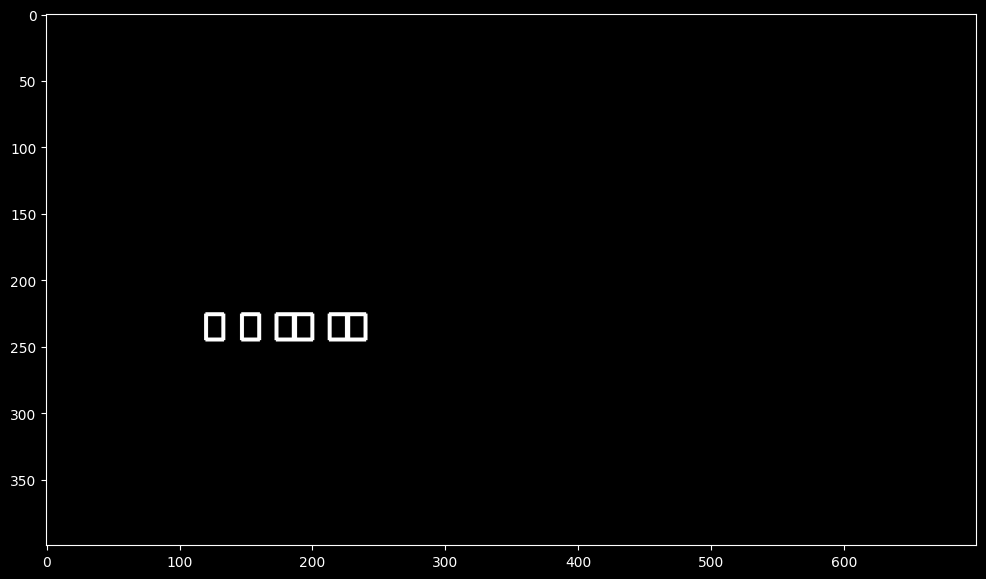

In [10]:
MAX_DIAG_MULTIPLYER = 5 # 5  대각선길이
MAX_ANGLE_DIFF = 10.0 # 12.0  1번째 contour와 2번째 contour 의 각도
MAX_AREA_DIFF = 0.05 # 0.5  면적의 차이
MAX_WIDTH_DIFF = 10 # 너비 차이
MAX_HEIGHT_DIFF = 0.001 # 높이 차이
MIN_N_MATCHED = 5  # 위에 조건들이 4개이상 충족해야 학번이다

# find_chars 함수로 지정한다. 나중에 재귀함수로 반복해서 찾기 위함이다. idx값 저장

def find_chars(contour_list):
    matched_result_idx = []
    
    
# 이중for문으로 예를들면 첫번째 contour와 두번째 contour를 비교

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            
# np.linalg.norm(a - b) 벡터 a와 벡터 b 사이의 거리를 구함.
# 삼각함수 사용
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) #면적의 비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] # 너비의 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] # 높이의 비율

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        # 학번의 총 자릿수는 9자리 이기 때문에 학번 후보군의 윤곽선 개수가 3보다 작으면 학번일 확률이 낮음
        matched_contours_idx.append(d1['idx'])
        # 육관선 개수가 3보다 작을때는 continue를 통해 제외
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
        # 최종 후보군에 넣어주기
        matched_result_idx.append(matched_contours_idx)
        # 아닌 것들을 다시 한번 비교 후 후보군에 넣어주기
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## 학번 인식

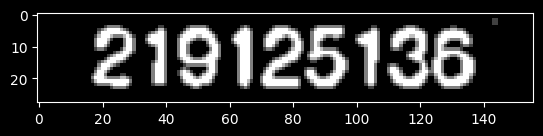

In [11]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])
    # 센터 좌표 구하기
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    # 학번의 기울어진 각도를 구하기 (삼각함수 이용)
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    # cv2.getRotationMatrix2D() 로테이션매트릭스를 구함.
    # cv2.warpAffine() 이미지 변형
    # cv2.getRectSubPix() 회전된 이미지에서 원하는 부분만을 잘라냄
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

## tesseract를 pytesseract를 이용해 python에 적용시키고 학번 따놓은 걸 인터넷에서 읽을수 있는 텍스트로 바꾸기

219125136


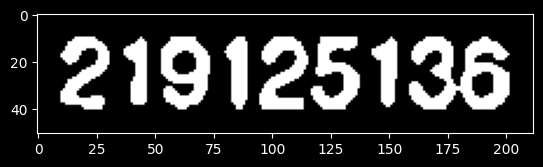

In [13]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')